In [2]:
import numpy as np
import pandas as pd
import scipy
import imageio
import math
import phylo as ph

from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
import warnings
sns.set(style="ticks")
plt.style.use("seaborn-whitegrid")

In [3]:
%load_ext blackcellmagic

# Preparation

All the expensive setup happens up here.

In [4]:
np.random.seed(820)
REGULAR_POKEMON = ph.vectorize_pokemon(ph.REGULAR_POKEMON_PATH)
SHINY_POKEMON = ph.vectorize_pokemon(ph.SHINY_POKEMON_PATH)

Vectorizing pokemon from /Users/vineshkannan/Documents/GitHub/phylo/images/regular/
Vector iteration 0
Vector iteration 100
Vector iteration 200
Vector iteration 300
Vector iteration 400
Vector iteration 500
Vector iteration 600
Done vectorizing
Vectorizing pokemon from /Users/vineshkannan/Documents/GitHub/phylo/images/shiny/
Vector iteration 0
Vector iteration 100
Vector iteration 200
Vector iteration 300
Vector iteration 400
Vector iteration 500
Vector iteration 600
Done vectorizing


In [5]:
known_creatures = list(REGULAR_POKEMON) + list(SHINY_POKEMON)
np.random.shuffle(known_creatures)

In [6]:
random_vectors = [ph.generate_random() for i in range(len(known_creatures))]
expect_base_pop = known_creatures + random_vectors
len(expect_base_pop)

2596

In [7]:
n_expected = 200
expected_from_n_sub = 50
expected_vectors = []
for i in range(n_expected):
    ev = ph.generate_expected(expect_base_pop, expected_from_n_sub)
    ev_ob = ph.outline_body(ev)
    expected_vectors.append(ev_ob)
    if i % 10 == 0:
        print(i)
print("Done.")

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
Done.


# Genetic Algorithm

## Pseudocode

- Select initial population
- While offspring have not converged
    - Score population on fitness function
    - Eliminate least fit members
    - Select parents to mate and perform 2D crossovers
    - Apply mutations to maintain diversity
        - Random mutations to members?
        - Introduce new members from the set of known creatures?
    - Update population
    - Measure change in overall fitness

In [8]:
WEIGHT = [-5.37720197,  2.15129582, -2.7828926 , 12.3475064 , -1.90558047]

def choose_from(options, n):
    idxs = np.random.choice(range(len(options)), n)
    return [options[i] for i in idxs]

def draw_normal(mu, sigma):
    return np.random.normal(mu, sigma, 1)[0]

def fitness(xv):
    qv = ph.col_freq(xv)
    s = np.dot(WEIGHT, qv).sum()
    return np.exp(s) / (1.0 + np.exp(s))

def crossover(p1, p2, x, y, r):
    m1 = np.array(p1).reshape(ph.M, ph.M)
    m2 = np.array(p2).reshape(ph.M, ph.M)
    for yi in range(y - r, y + r + 1):
        for xi in range(x - r, x + r + 1):
            if ph.in_im(xi, yi):
                from1 = np.uint8(m1[yi][xi])
                from2 = np.uint8(m2[yi][xi])
                if from2 > 0:
                    m1[yi][xi] = from2
                if from1 > 0:
                    m2[yi][xi] = from1
    c1 = m1.reshape(ph.M**2)
    c2 = m2.reshape(ph.M**2)
    return c1, c2

def mutate_form(cx, px):
    subsample = np.array([cx, cx, px, px] + [ph.generate_random() for i in range(2)])
    ev = ph.expect_from_subsample(subsample)
    bv = ph.outline_body(ev)
    return bv

def rank_generation(generation):
    rdf = pd.DataFrame()
    rdf["x"] = generation
    rdf["fitness"] = [fitness(xv) for xv in generation]
    rdf = rdf.sort_values(by="fitness", ascending=False).reset_index(drop=True)
    return rdf

def imrow(vecs, scale=1):
    ims = [ph.showim(v, scale) for v in vecs]
    full = Image.new(ph.MODE, (len(ims) * ph.M * scale, ph.M * scale))
    for i in range(len(ims)):
        full.paste(ims[i], (i * ph.M * scale, 0))
    return full

def imgrid(rows, scale=1):
    ims = [imrow(row, scale) for row in rows]
    full = Image.new(ph.MODE, (len(rows[0]) * ph.M * scale, len(rows) * ph.M * scale))
    for i in range(len(ims)):
        full.paste(ims[i], (0, i * ph.M * scale))
    return full

def neighbors_block(x, y, r=1):
    neigh = []
    for xi in range(x - r, x + r + 1):
        for yi in range(y - r, y + r + 1):
            if ph.in_im(xi, yi):
                neigh.append((xi, yi))
    return neigh

def smoother(method=None, threshold=0.25, radius=1):
    def do_transform(cell, x, y, mat):
        neigh = neighbors_block(x, y, radius)
        n_vals = [mat[yn][xn] for xn, yn in neigh]
        palette = []
        if method == "light":
            palette = range(1, ph.Q)
        if method == "dark":
            palette = range(ph.Q - 1, 0, -1)
        if method == "mid":
            palette = [2, 1, 3]
        for target in palette:
            match = [1 if v == target else 0 for v in n_vals]
            ratio = sum(match) / len(match)
            if ratio >= threshold:
                return target
        return cell
    return do_transform

def smooth_quanta(xv, method, threshold=0.25, radius=1):
    sm = smoother(method, threshold, radius)
    cv = ph.cell_transform(xv, sm)
    bv = ph.outline_body(cv)
    return bv

In [9]:
population = choose_from(known_creatures, 50) + choose_from(expected_vectors, 10)

In [10]:
pop_half = math.floor(len(population) / 2)
pop_quart = math.floor(pop_half / 2)
xc_mean = math.floor(ph.M / 2)
yc_mean = math.floor(ph.M / 2)
coord_s = 10
radius_mean = 4
radius_s = 2
t = 0
max_turns = 5
scores = []
generations = []
while t < max_turns:
    # Mating
    new_pop = []
    mate_idxs = np.random.choice(range(len(population)), len(population), replace=False)
    for m in range(pop_quart):
        p1 = population[mate_idxs[m*2]]
        p2 = population[mate_idxs[(m*2) + 1]]
        xc = math.floor(draw_normal(xc_mean, coord_s))
        yc = math.floor(draw_normal(yc_mean, coord_s))
        radius = math.floor(draw_normal(radius_mean, radius_s))
        c1, c2 = crossover(p1, p2, xc, yc, radius)
        # new_pop.append(p1)
        # new_pop.append(p2)
        new_pop.append(c1)
        new_pop.append(c2)
        l1 = smooth_quanta(c1, "mid", 0.5)
        l2 = smooth_quanta(c2, "mid", 0.5)
        new_pop.append(l1)
        new_pop.append(l2)
        # new_pop.append(mutate_form(c1, p1))
        # new_pop.append(mutate_form(c2, p2))
    # Updating
    population = new_pop
    generations.append(population)
    scores.append(max([fitness(pv) for pv in population]))
    print("Completed Turn {}".format(t))
    t += 1
print("Done.")

Completed Turn 0
Completed Turn 1
Completed Turn 2
Completed Turn 3
Completed Turn 4
Done.


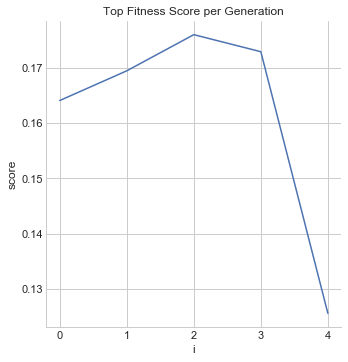

In [11]:
sdf = pd.DataFrame()
sdf["i"] = range(len(scores))
sdf["score"] = scores
sns.relplot(x="i", y="score", kind="line", data=sdf)
plt.title("Top Fitness Score per Generation")
plt.xticks(range(0, t))
plt.show()

In [12]:
best_gen = 2
rdf = rank_generation(generations[best_gen])

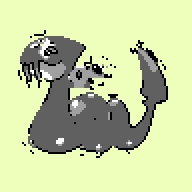

In [13]:
ph.showim(rdf["x"][0], scale=2)

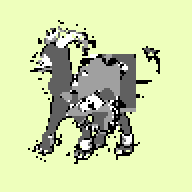

In [371]:
ph.showim(generations[3][8], scale=2)

In [319]:
# for j in range(10):
#     rxv = rdf["x"][j]
#     ph.showim(rxv, scale=2).show()

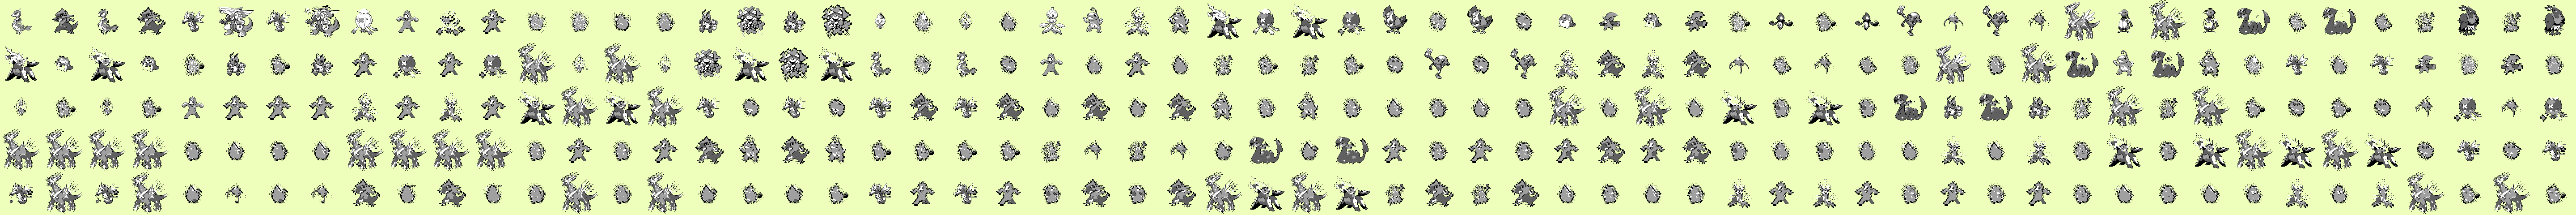

In [14]:
imgrid(generations)

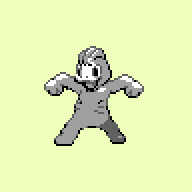

In [21]:
ph.showim(generations[2][4], scale=2)

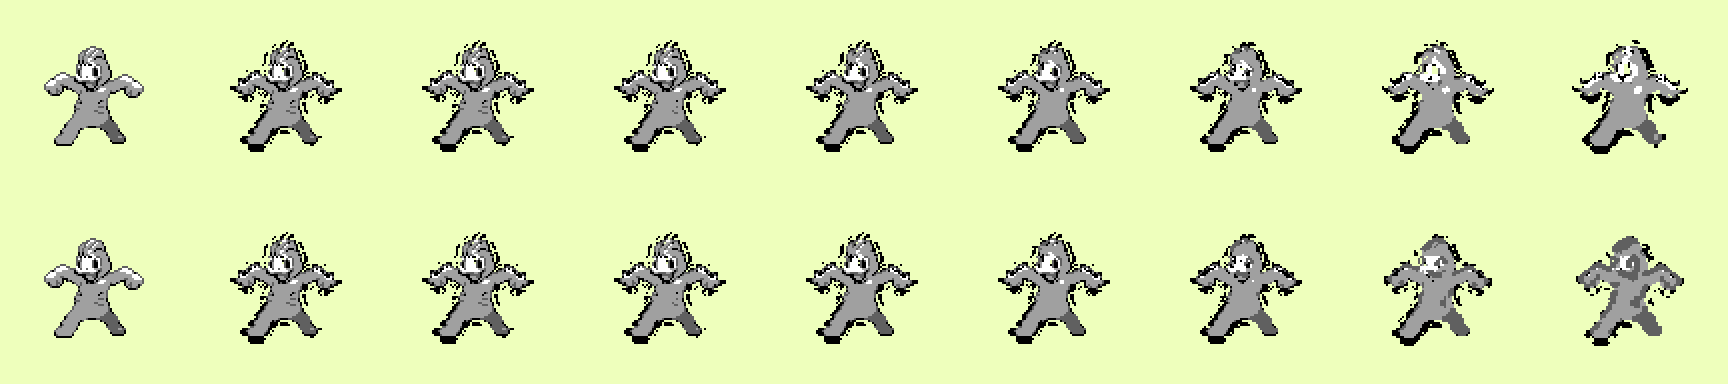

In [22]:
sv = generations[2][4]
lvs = [smooth_quanta(sv, "light", 1.0 - t) for t in np.arange(0, 1.0, 0.125)]
dvs = [smooth_quanta(sv, "dark", 1.0 - t) for t in np.arange(0, 1.0, 0.125)]
imgrid([[sv, *lvs], [sv, *dvs]], scale=2)